# Import Libraries and Functions

In [1]:
%reload_ext autoreload

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns 
import numpy as np
from math import sqrt
from datetime import date
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

from data_cleaner import overall_cleaner, boxcox_trans

# Importing Data and Cleaning

In [3]:
user_df = pd.read_csv('datasets/googleplaystore_user_reviews.csv')
overall_df = pd.read_csv('datasets/googleplaystore.csv')

In [4]:
user_df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [5]:
overall_df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [6]:
overall_df = overall_df[overall_df.Rating < 5.1]

In [7]:
overall_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9366 entries, 0 to 10840
Data columns (total 13 columns):
App               9366 non-null object
Category          9366 non-null object
Rating            9366 non-null float64
Reviews           9366 non-null object
Size              9366 non-null object
Installs          9366 non-null object
Type              9366 non-null object
Price             9366 non-null object
Content Rating    9366 non-null object
Genres            9366 non-null object
Last Updated      9366 non-null object
Current Ver       9362 non-null object
Android Ver       9364 non-null object
dtypes: float64(1), object(12)
memory usage: 1.0+ MB


In [8]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
App                       64295 non-null object
Translated_Review         37427 non-null object
Sentiment                 37432 non-null object
Sentiment_Polarity        37432 non-null float64
Sentiment_Subjectivity    37432 non-null float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


In [9]:
user_df_processed = user_df.groupby('App').mean().copy().dropna()

In [10]:
user_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 865 entries, 10 Best Foods for You to Housing-Real Estate & Property
Data columns (total 2 columns):
Sentiment_Polarity        865 non-null float64
Sentiment_Subjectivity    865 non-null float64
dtypes: float64(2)
memory usage: 20.3+ KB


In [11]:
overall_df.Price = overall_df.Price.apply(lambda x: x.replace('$', '')).astype('float')
overall_df.Installs = overall_df.Installs.apply(lambda x: x.replace('+', '')).apply(lambda x: x.replace(',', '')).astype('int')

In [12]:
overall_df.drop_duplicates('App', inplace=True)

In [98]:
overall_df_processed = overall_cleaner(overall_df, ['App', 'Rating', 'Reviews', 'Installs', 'Price', 'Last Updated'])
overall_df_processed.head()

,App,Rating,Reviews,Installs,Price,Last Updated
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,10000,0.0,"January 7, 2018"
1,Coloring book moana,3.9,967,500000,0.0,"January 15, 2018"
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",4.7,87510,5000000,0.0,"August 1, 2018"
3,Sketch - Draw & Paint,4.5,215644,50000000,0.0,"June 8, 2018"
4,Pixel Draw - Number Art Coloring Book,4.3,967,100000,0.0,"June 20, 2018"


In [99]:
overall_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8196 entries, 0 to 10840
Data columns (total 6 columns):
App             8196 non-null object
Rating          8196 non-null float64
Reviews         8196 non-null object
Installs        8196 non-null int64
Price           8196 non-null float64
Last Updated    8196 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 448.2+ KB


In [100]:
overall_df_processed['Last Updated'] = pd.to_datetime(overall_df_processed['Last Updated'])
overall_df_processed['Last Updated'] = overall_df_processed['Last Updated'].apply(lambda x: x.date())
overall_df_processed['days_since_update'] = date.today() - overall_df_processed['Last Updated']
overall_df_processed['delta'] = overall_df_processed['days_since_update'].apply(lambda x: x.days)
overall_df_processed.drop(['days_since_update', 'Last Updated'], axis=1, inplace=True)
overall_df_processed.Reviews = pd.to_numeric(overall_df_processed.Reviews)
overall_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8196 entries, 0 to 10840
Data columns (total 6 columns):
App         8196 non-null object
Rating      8196 non-null float64
Reviews     8196 non-null int64
Installs    8196 non-null int64
Price       8196 non-null float64
delta       8196 non-null int64
dtypes: float64(2), int64(3), object(1)
memory usage: 448.2+ KB


# Merging on 'App'

In [110]:
merged_df = overall_df_processed.merge(user_df_processed, how = 'inner', on = 'App')
merged_df.set_index('App', inplace=True)
merged_df.head()

,Rating,Reviews,Installs,Price,delta,Sentiment_Polarity,Sentiment_Subjectivity
App,,,,,,,
Coloring book moana,3.9,967,500000,0.0,748,0.152652,0.641540
Garden Coloring Book,4.4,13791,1000000,0.0,865,0.268483,0.523447
FlipaClip - Cartoon animation,4.3,194216,5000000,0.0,548,0.412649,0.679226
Boys Photo Editor - Six Pack & Men's Suit,4.1,654,100000,0.0,684,0.283509,0.479298
Colorfit - Drawing & Coloring,4.7,20260,500000,0.0,844,0.171836,0.572762


In [111]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 816 entries, Coloring book moana to A+ Gallery - Photos & Videos
Data columns (total 7 columns):
Rating                    816 non-null float64
Reviews                   816 non-null int64
Installs                  816 non-null int64
Price                     816 non-null float64
delta                     816 non-null int64
Sentiment_Polarity        816 non-null float64
Sentiment_Subjectivity    816 non-null float64
dtypes: float64(4), int64(3)
memory usage: 51.0+ KB


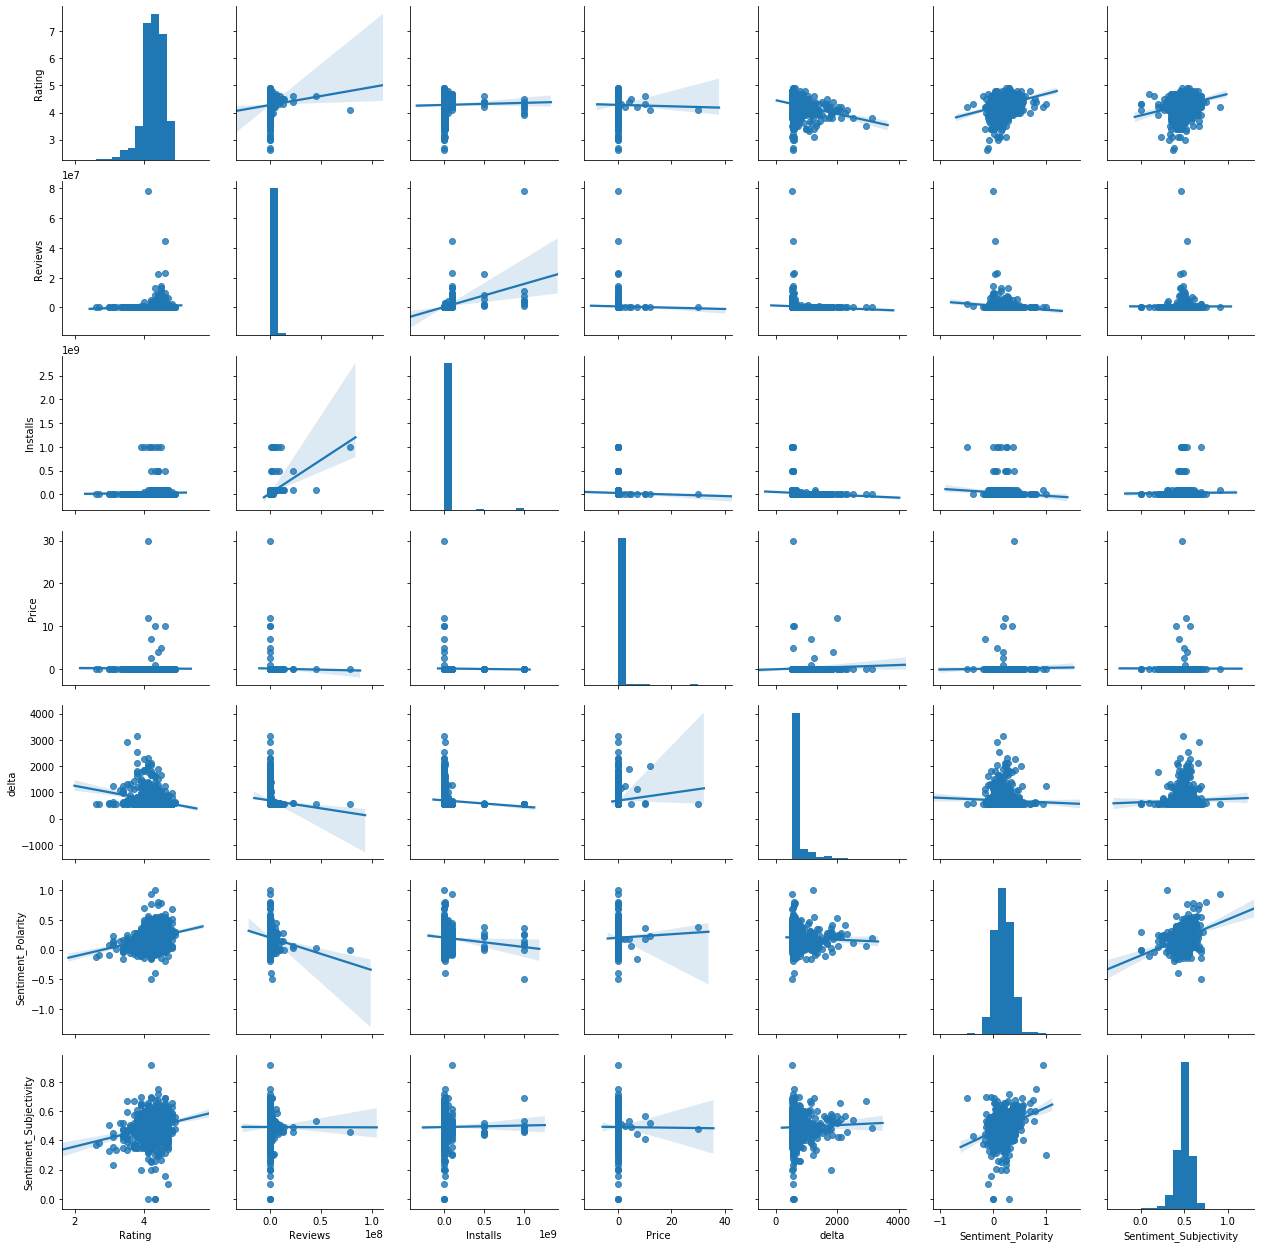

In [112]:
sns.pairplot(merged_df, kind='reg')

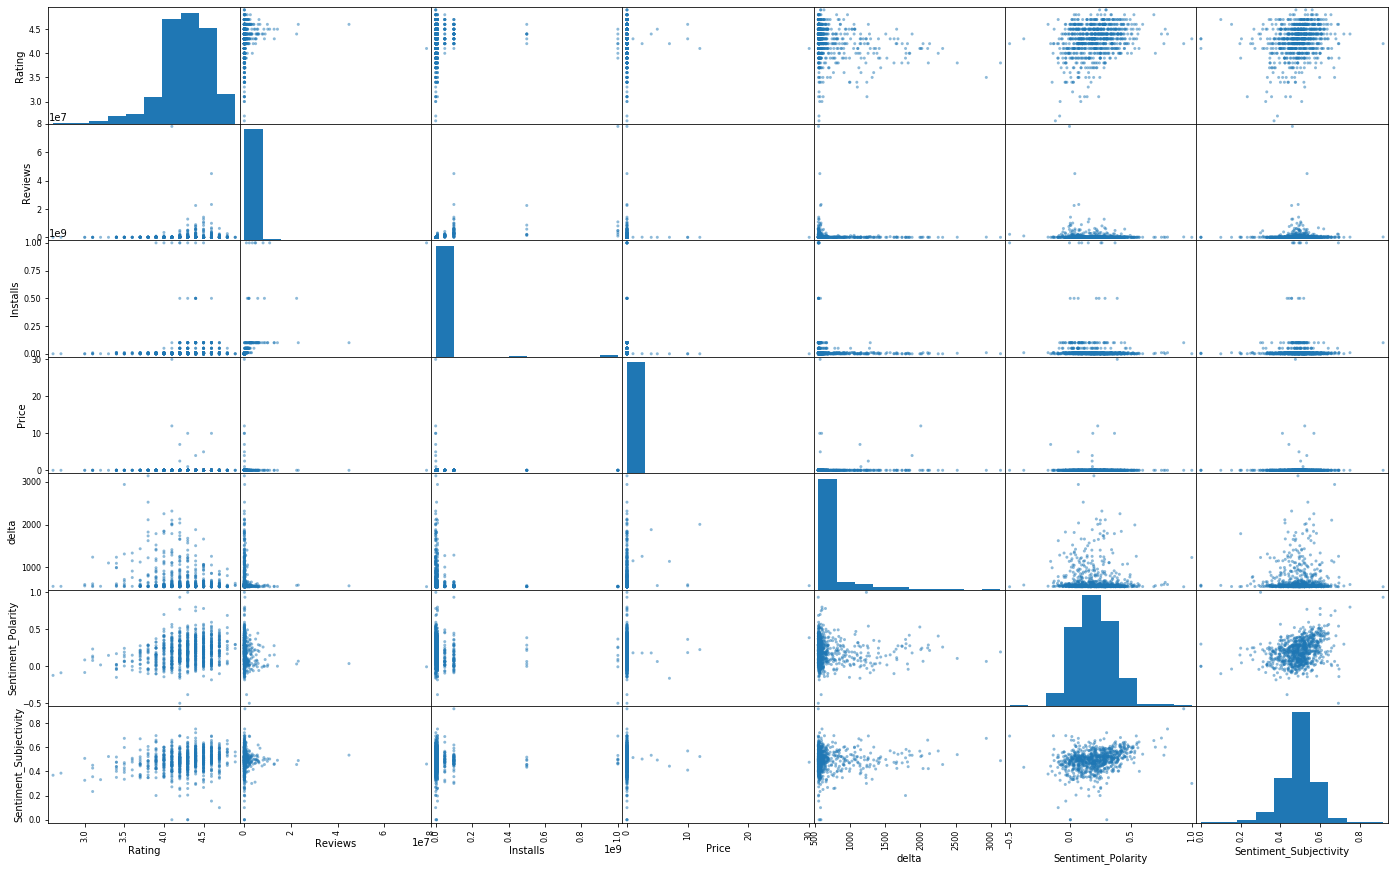

In [113]:
pd.plotting.scatter_matrix(merged_df,figsize=(24,15));
plt.savefig('nontransformed.png')

In [114]:
boxcox_trans(merged_df, 'Reviews', remove_col=True)
boxcox_trans(merged_df, 'Rating', remove_col=True)
boxcox_trans(merged_df, 'Installs', remove_col=True)
boxcox_trans(merged_df, 'delta', remove_col=True)

,Price,Sentiment_Polarity,Sentiment_Subjectivity,boxcox_Reviews,boxcox_Rating,boxcox_Installs,boxcox_delta
App,,,,,,,
Coloring book moana,0.0,0.152652,0.641540,6.528624,301.908156,13.745769,0.202608
Garden Coloring Book,0.0,0.268483,0.523447,8.876018,582.141657,14.507654,0.202608
FlipaClip - Cartoon animation,0.0,0.412649,0.679226,11.120358,513.676239,16.291060,0.202608
Boys Photo Editor - Six Pack & Men's Suit,0.0,0.283509,0.479298,6.175138,396.374098,11.990960,0.202608
Colorfit - Drawing & Coloring,0.0,0.171836,0.572762,9.208002,833.526148,13.745769,0.202608
...,...,...,...,...,...,...,...
"AD - Nieuws, Sport, Regio & Entertainment",0.0,0.161824,0.465806,8.628608,226.671838,14.507654,0.202608
AppLock,0.0,0.016233,0.499941,13.745529,582.141657,19.664745,0.202608
Diary with lock password,0.0,0.292267,0.509656,11.053111,513.676239,16.291060,0.202608


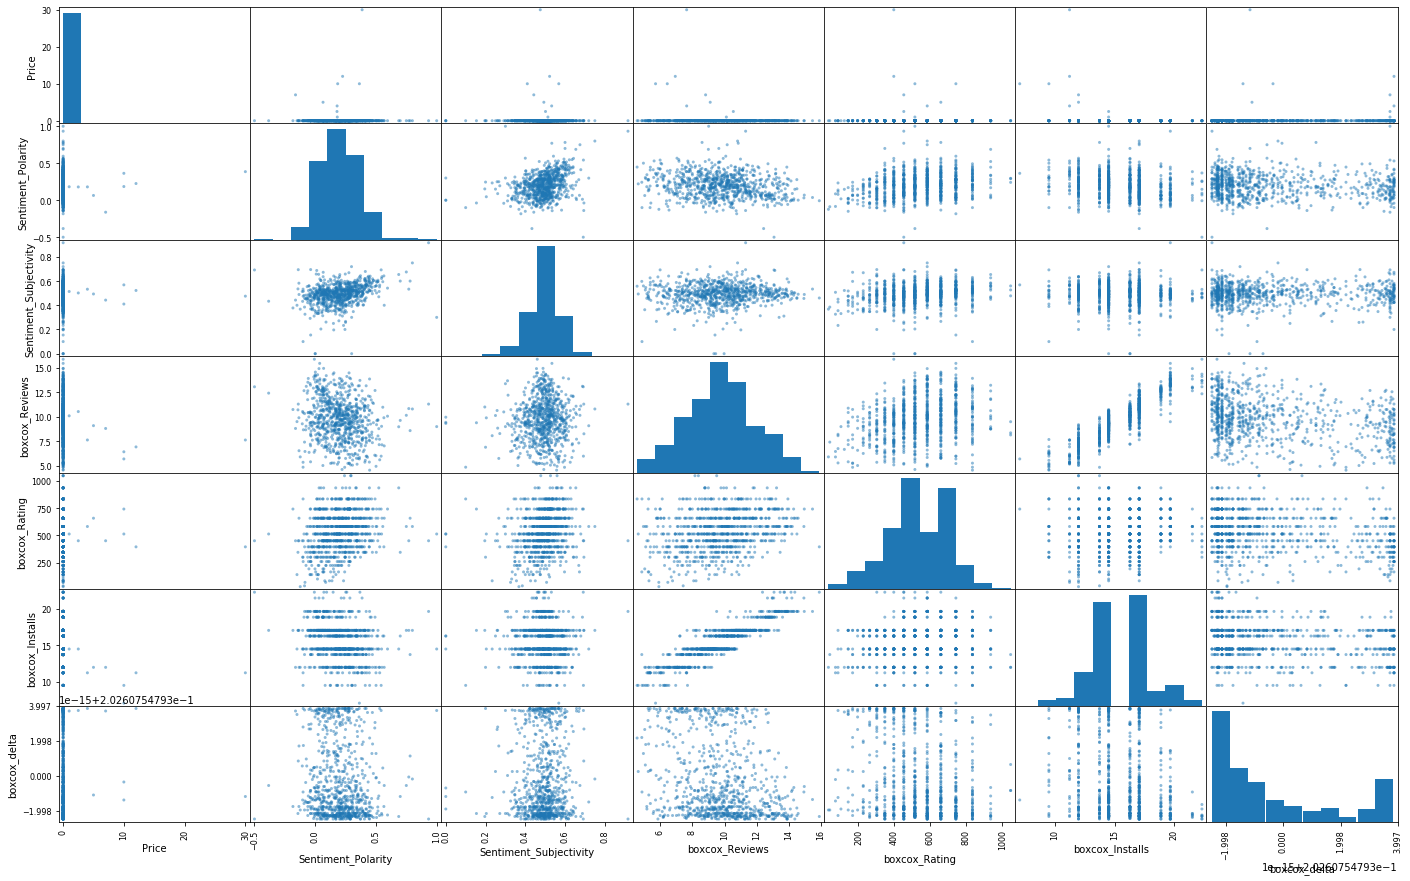

In [115]:
pd.plotting.scatter_matrix(merged_df, figsize=(24,15))
plt.show();

In [116]:
merged_df

,Price,Sentiment_Polarity,Sentiment_Subjectivity,boxcox_Reviews,boxcox_Rating,boxcox_Installs,boxcox_delta
App,,,,,,,
Coloring book moana,0.0,0.152652,0.641540,6.528624,301.908156,13.745769,0.202608
Garden Coloring Book,0.0,0.268483,0.523447,8.876018,582.141657,14.507654,0.202608
FlipaClip - Cartoon animation,0.0,0.412649,0.679226,11.120358,513.676239,16.291060,0.202608
Boys Photo Editor - Six Pack & Men's Suit,0.0,0.283509,0.479298,6.175138,396.374098,11.990960,0.202608
Colorfit - Drawing & Coloring,0.0,0.171836,0.572762,9.208002,833.526148,13.745769,0.202608
...,...,...,...,...,...,...,...
"AD - Nieuws, Sport, Regio & Entertainment",0.0,0.161824,0.465806,8.628608,226.671838,14.507654,0.202608
AppLock,0.0,0.016233,0.499941,13.745529,582.141657,19.664745,0.202608
Diary with lock password,0.0,0.292267,0.509656,11.053111,513.676239,16.291060,0.202608


In [118]:
target = merged_df['boxcox_Installs']
features = merged_df.drop('boxcox_Installs', axis=1)

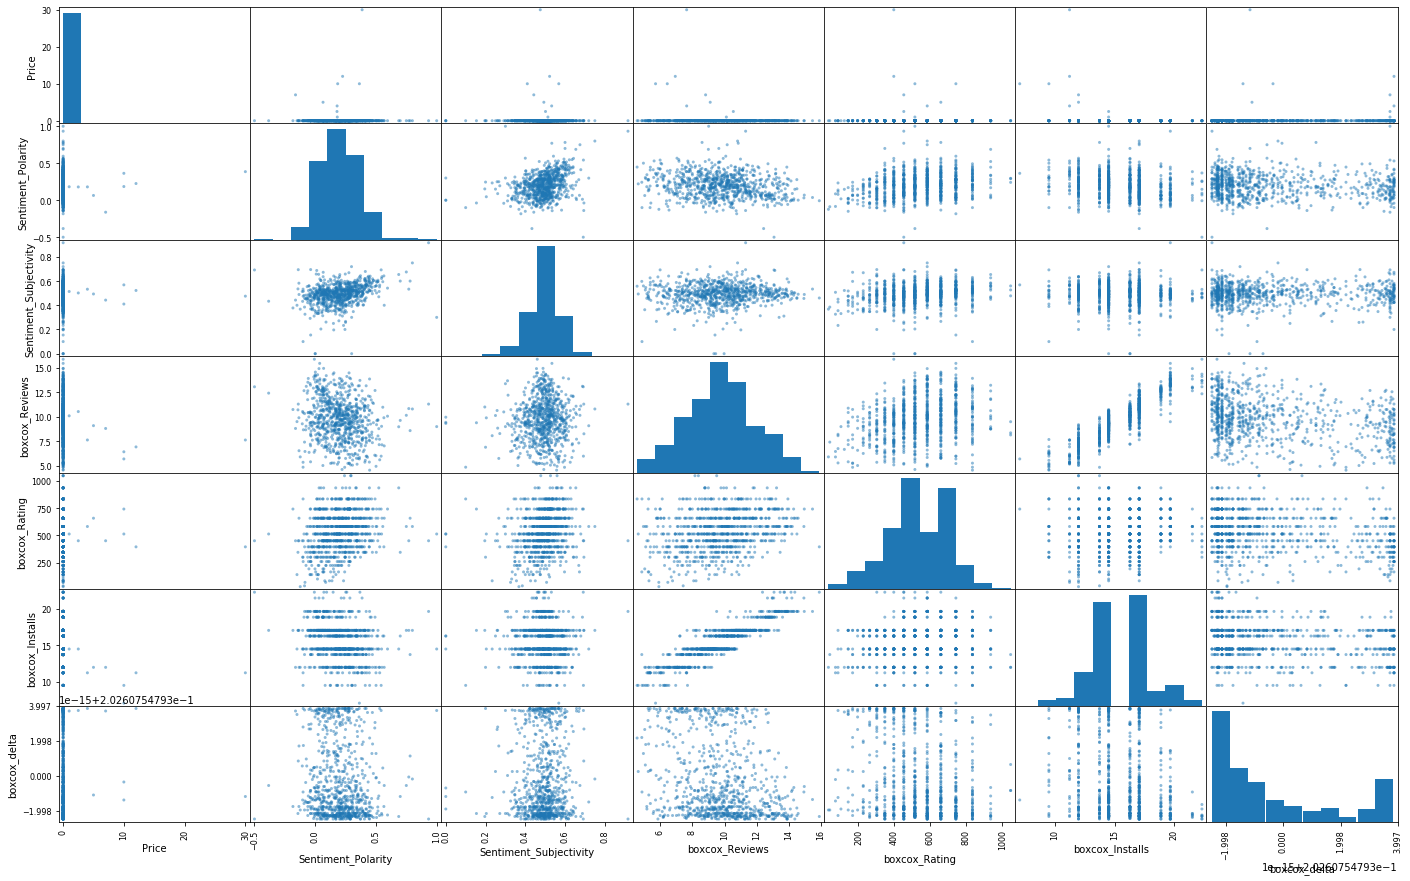

In [120]:
pd.plotting.scatter_matrix(merged_df, figsize=(24,15))
plt.savefig('transformed.png')

In [122]:
scaler = StandardScaler()
ss_df = pd.DataFrame(scaler.fit_transform(merged_df), index=merged_df.index, columns=merged_df.columns)

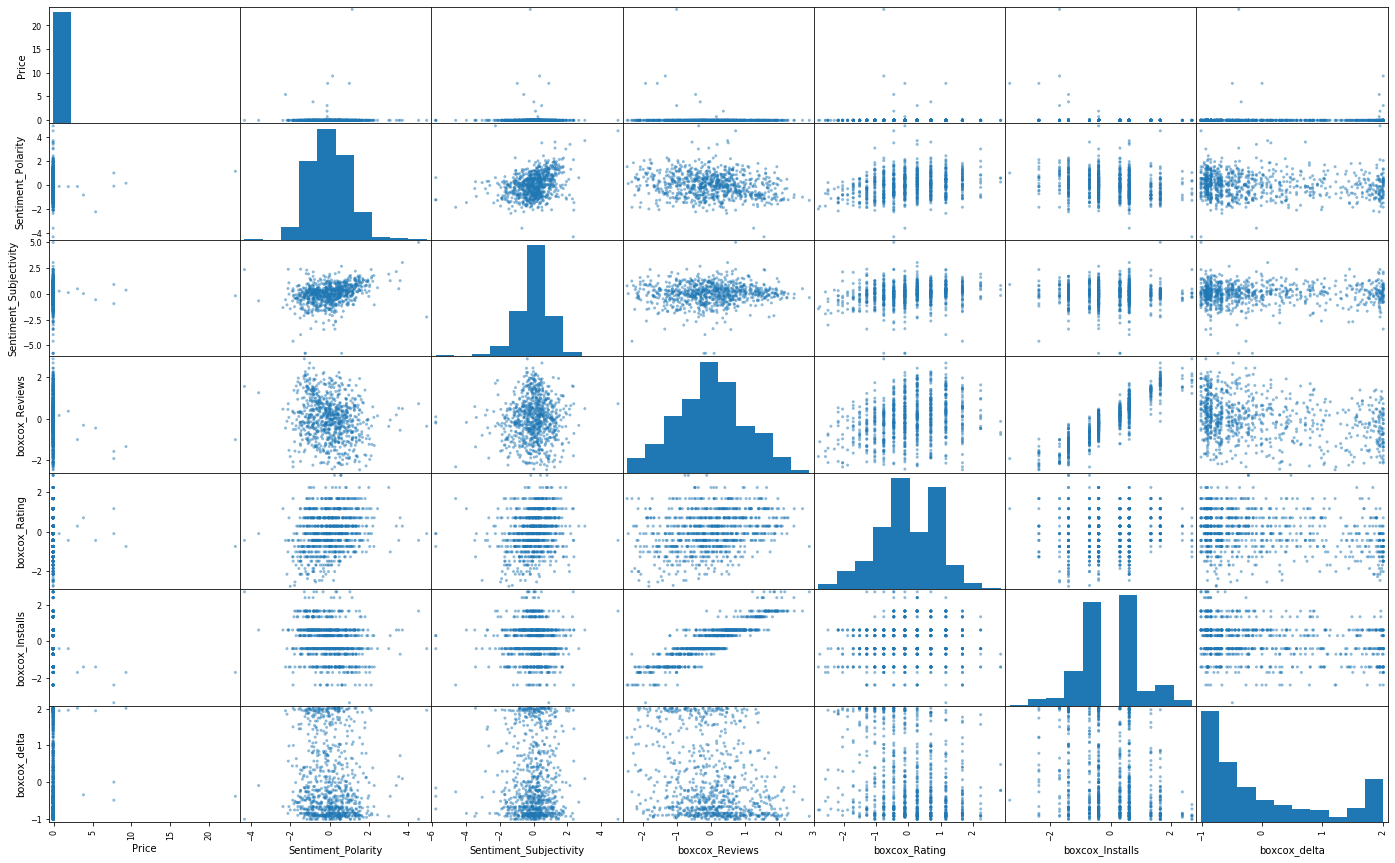

In [123]:
pd.plotting.scatter_matrix(ss_df, figsize=(24,15));

In [124]:
ss_df.corr()

,Price,Sentiment_Polarity,Sentiment_Subjectivity,boxcox_Reviews,boxcox_Rating,boxcox_Installs,boxcox_delta
Price,1.000000,0.023674,-0.003546,-0.084913,-0.020040,-0.146594,0.033151
Sentiment_Polarity,0.023674,1.000000,0.319732,-0.191458,0.244924,-0.220625,-0.090276
Sentiment_Subjectivity,-0.003546,0.319732,1.000000,0.055535,0.205513,-0.005800,0.016829
boxcox_Reviews,-0.084913,-0.191458,0.055535,1.000000,0.280680,0.898443,-0.275510
boxcox_Rating,-0.020040,0.244924,0.205513,0.280680,1.000000,0.117700,-0.252183
boxcox_Installs,-0.146594,-0.220625,-0.005800,0.898443,0.117700,1.000000,-0.223815
boxcox_delta,0.033151,-0.090276,0.016829,-0.275510,-0.252183,-0.223815,1.000000


In [125]:
ss_df = ss_df[(np.abs(stats.zscore(ss_df)) < 2).all(axis=1)]
ss_df.corr()

,Price,Sentiment_Polarity,Sentiment_Subjectivity,boxcox_Reviews,boxcox_Rating,boxcox_Installs,boxcox_delta
Price,1.000000,-0.007891,0.007341,0.013694,-0.024322,-0.027727,0.113173
Sentiment_Polarity,-0.007891,1.000000,0.312081,-0.215643,0.244820,-0.251272,-0.120929
Sentiment_Subjectivity,0.007341,0.312081,1.000000,0.056140,0.253835,-0.031033,-0.002888
boxcox_Reviews,0.013694,-0.215643,0.056140,1.000000,0.255427,0.890614,-0.196772
boxcox_Rating,-0.024322,0.244820,0.253835,0.255427,1.000000,0.110155,-0.215706
boxcox_Installs,-0.027727,-0.251272,-0.031033,0.890614,0.110155,1.000000,-0.146590
boxcox_delta,0.113173,-0.120929,-0.002888,-0.196772,-0.215706,-0.146590,1.000000


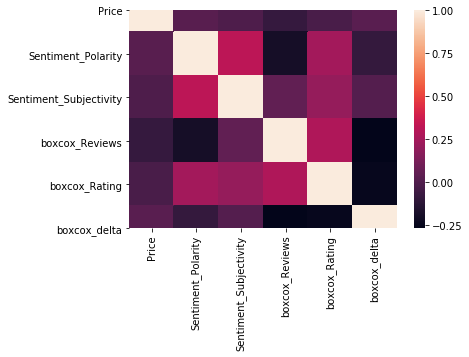

In [127]:
sns.heatmap(features.corr())

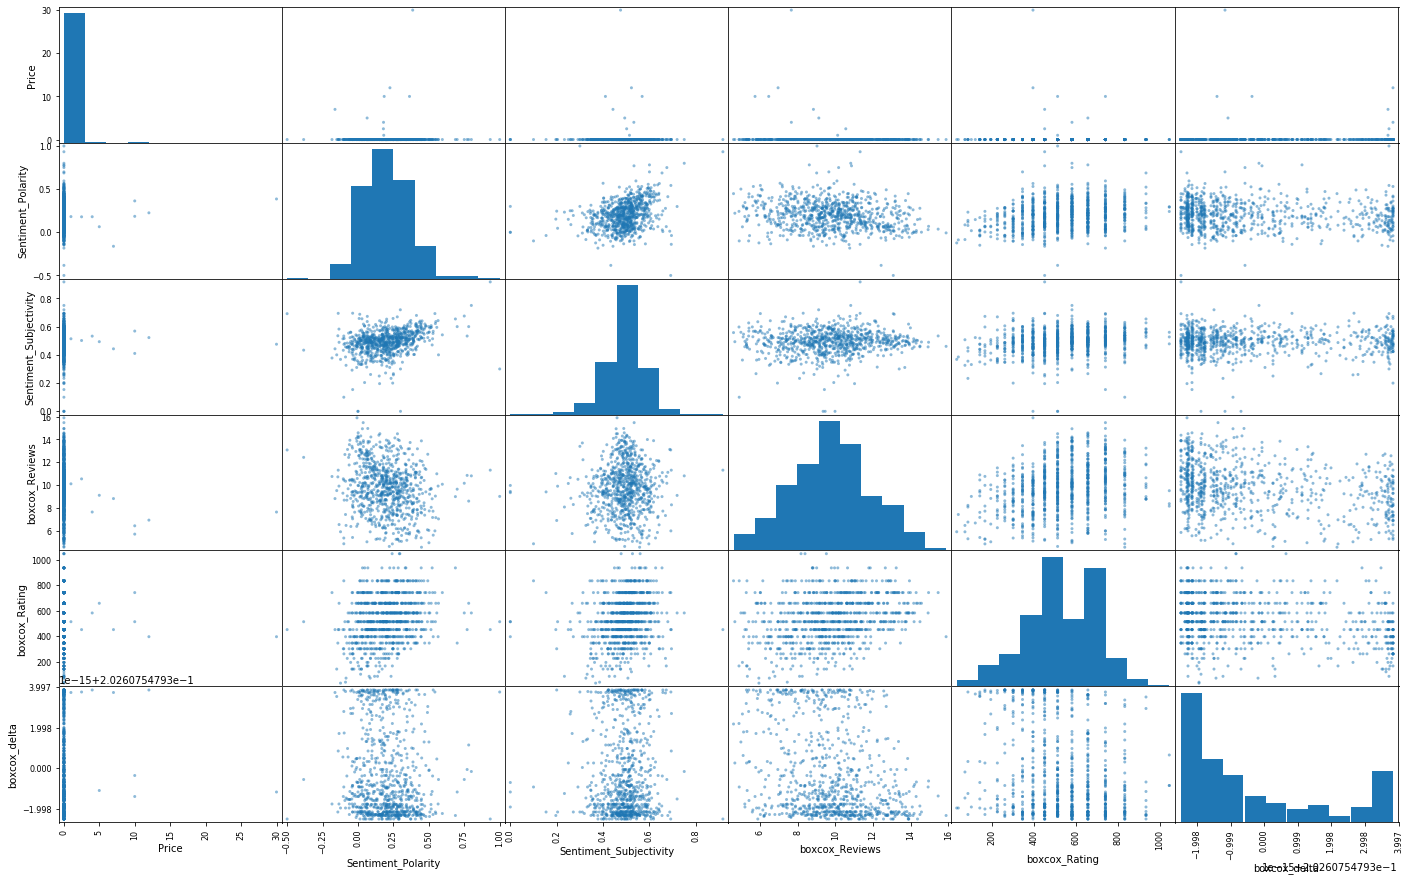

In [128]:
pd.plotting.scatter_matrix(features, figsize=(24,15));
plt.savefig('endresult.png')

# Modelling

In [130]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = .2, random_state=4)

In [131]:
train_df = pd.concat([X_train,y_train],axis=1)

In [133]:
train_df

,Price,Sentiment_Polarity,Sentiment_Subjectivity,boxcox_Reviews,boxcox_Rating,boxcox_delta,boxcox_Installs
App,,,,,,,
Babbel – Learn Spanish,0.0,0.309364,0.544709,10.057898,582.141657,0.202608,14.507654
Colorful Glitter Neon Butterfly Keyboard Theme,0.0,0.206406,0.582507,7.204528,513.676239,0.202608,13.745769
Alto's Adventure,0.0,0.039827,0.526132,11.926479,741.466042,0.202608,17.065360
Entel,0.0,0.018577,0.331314,9.013504,102.784924,0.202608,14.507654
"Fabulous: Motivate Me! Meditate, Relax, Sleep",0.0,0.191996,0.526581,11.166493,741.466042,0.202608,16.291060
...,...,...,...,...,...,...,...
Disney Heroes: Battle Mode,0.0,-0.005000,0.358333,10.583030,741.466042,0.202608,16.291060
HTC Calendar,0.0,-0.037626,0.694949,8.279605,301.908156,0.202608,17.065360
Fun Kid Racing - Motocross,0.0,0.190795,0.513577,10.130896,396.374098,0.202608,17.065360


In [134]:
x_columns = '+'.join(train_df.columns[:-1])

f = f'boxcox_Installs ~ {x_columns}'

model = ols(formula=f, data=train_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        boxcox_Installs   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     611.2
Date:                Sun, 02 Feb 2020   Prob (F-statistic):          4.09e-242
Time:                        16:27:17   Log-Likelihood:                -949.82
No. Observations:                 652   AIC:                             1912.
Df Residuals:                     646   BIC:                             1939.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5.8095      0.291     19.933      0.000       5.237       6.382
Price                     -0.1295      0.030     -4.341      0.000      -0.188      -0.071
Sentiment_Polarity         0.0827      0.280      0.296      0.768      -0.467       0.632
Sentiment_Subjectivity    -0.7507      0.509     -1.476      0.140      -1.749       0.248
boxcox_Reviews             1.1067      0.021     52.269      0.000       1.065       1.148
boxcox_Rating             -0.0019      0.000     -7.720      0.000      -0.002      -0.001
boxcox_delta               1.1771      0.059     19.933      0.000       1.061       1.293
==============================================================================
Omnibus:                       21.724   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.502
Skew:                           0.344   Prob(JB):                     1.07e-06
Kurtosis:                       3.735   Cond. No.                     2.91e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.44e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

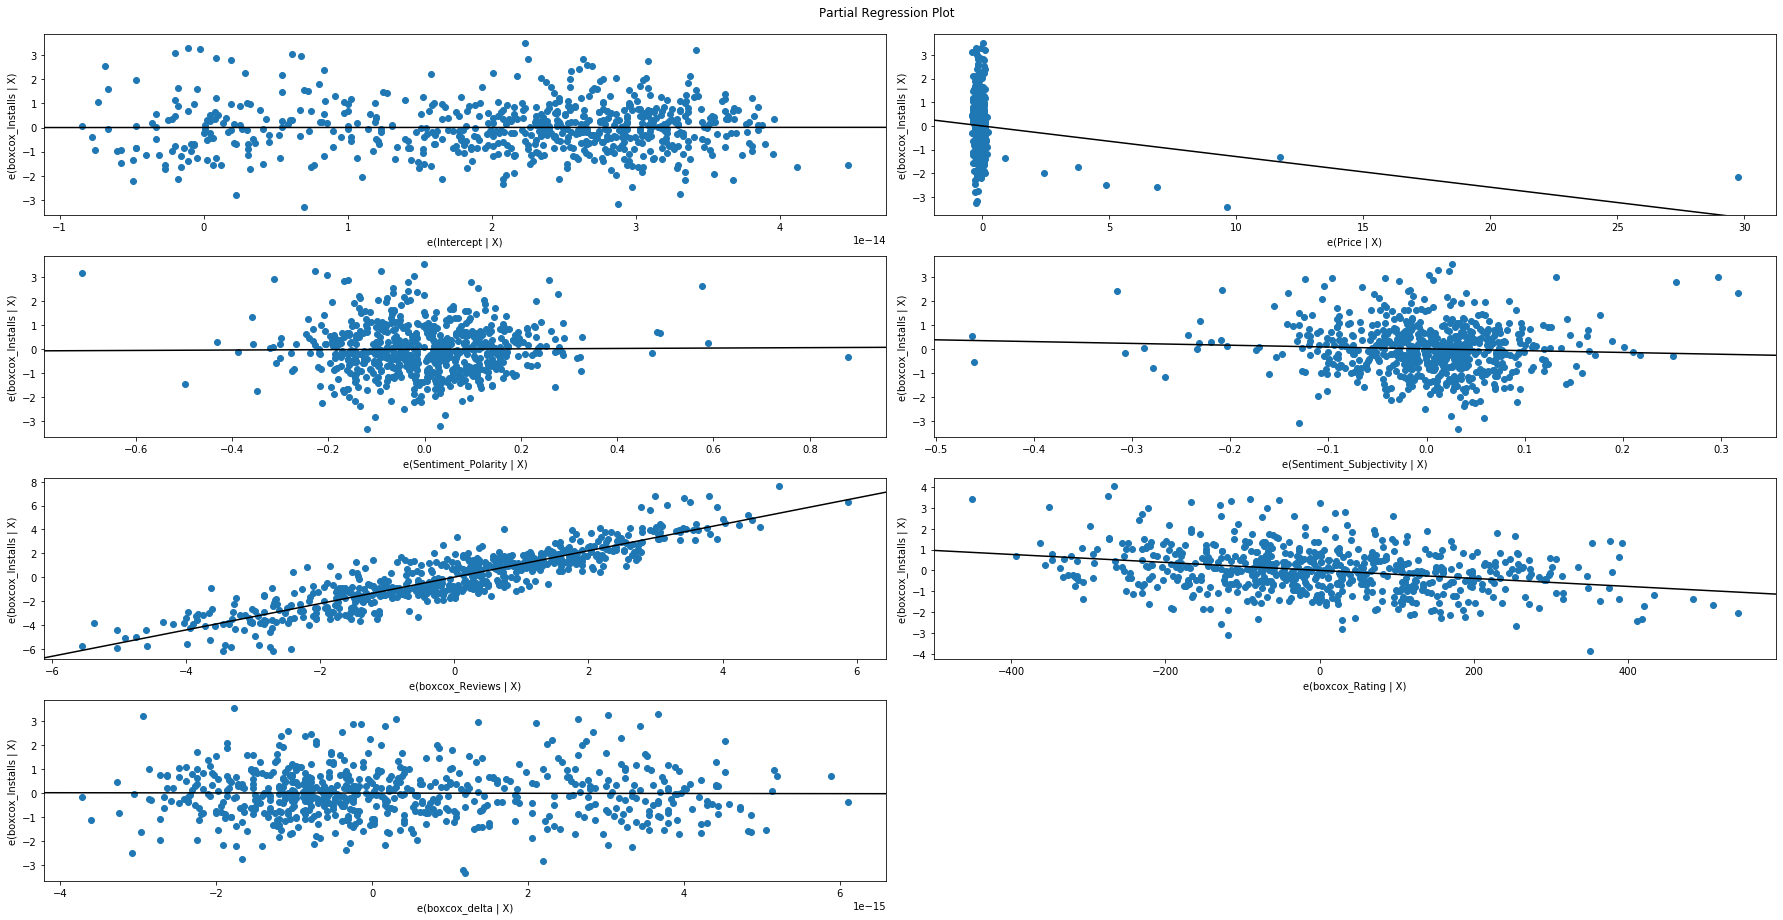

In [135]:
fig = plt.figure(figsize=(25,13))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)
plt.savefig('partregressgrid.png')

In [136]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)
train_res = y_hat_train - y_train
test_res = y_hat_test - y_test

In [162]:
train_rmse = sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = sqrt(mean_squared_error(y_test, y_hat_test))
test_set_r2 = r2_score(y_test, y_hat_test)
print('Train Root Mean Squarred Error:', train_rmse)
print('Test Root Mean Squarred Error:', test_rmse)
print('Test R-squared', test_set_r2)

Train Root Mean Squarred Error: 1.0385588710890363
Test Root Mean Squarred Error: 1.006304544728141
Test R-squared 0.856513665517396


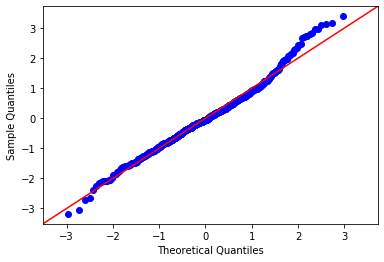

In [141]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45',fit=True)

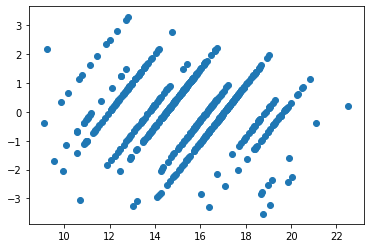

In [142]:
plt.scatter(y_hat_train, train_res)

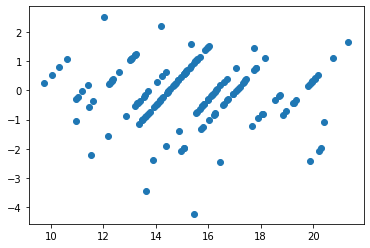

In [143]:
plt.scatter(y_hat_test, test_res)

In [145]:
cv_20_results  = np.mean(cross_val_score(linreg, features, target, cv=20,  scoring='neg_mean_squared_error'))
cv_20_results

-1.1393274756683147

In [147]:
scores = cross_val_score(linreg, features, target, cv=20)
scores.mean(), scores.std()

(0.7641409377015995, 0.11396398275588111)

In [148]:
ridgeReg = Ridge(alpha=0.05, normalize=True)
ridgeReg.fit(X_train, y_train)
ridge_train_score = ridgeReg.score(X_train, y_train)
ridge_test_score = ridgeReg.score(X_test, y_test)

ridge_train_score, ridge_test_score

(0.8229887252639474, 0.8526327283169078)

In [149]:
lassoReg = Lasso(alpha=0.05, normalize=True)
lassoReg.fit(X_train, y_train)
lasso_train_score = lassoReg.score(X_train, y_train)
lasso_test_score = lassoReg.score(X_test, y_test)

lasso_train_score, lasso_test_score

(0.5369309493513468, 0.5605843873501968)

In [150]:
elasticN = ElasticNet(alpha=0.05, normalize=True)
elasticN.fit(X_train, y_train)
elasticN_train = elasticN.score(X_train, y_train)
elasticN_test = elasticN.score(X_test, y_test)

elasticN_train, elasticN_test

(0.06463832456448704, 0.06763938424484572)

# Refined model, based on coefficients (delta, reviews, polarity)

In [152]:
f = f'boxcox_Installs ~ boxcox_delta + boxcox_Reviews + Sentiment_Polarity'

model = ols(formula=f, data=train_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        boxcox_Installs   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     1321.
Date:                Sun, 02 Feb 2020   Prob (F-statistic):          1.55e-229
Time:                        16:36:41   Log-Likelihood:                -989.68
No. Observations:                 652   AIC:                             1985.
Df Residuals:                     649   BIC:                             1999.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.0711      0.219     23.112      0.000       4.640       5.502
boxcox_delta           1.0274      0.044     23.112      0.000       0.940       1.115
boxcox_Reviews         1.0580      0.021     49.975      0.000       1.016       1.100
Sentiment_Polarity    -0.7270      0.271     -2.681      0.008      -1.259      -0.194
==============================================================================
Omnibus:                       21.997   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.076
Skew:                           0.256   Prob(JB):                     1.47e-08
Kurtosis:                       4.032   Cond. No.                     5.08e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.56e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

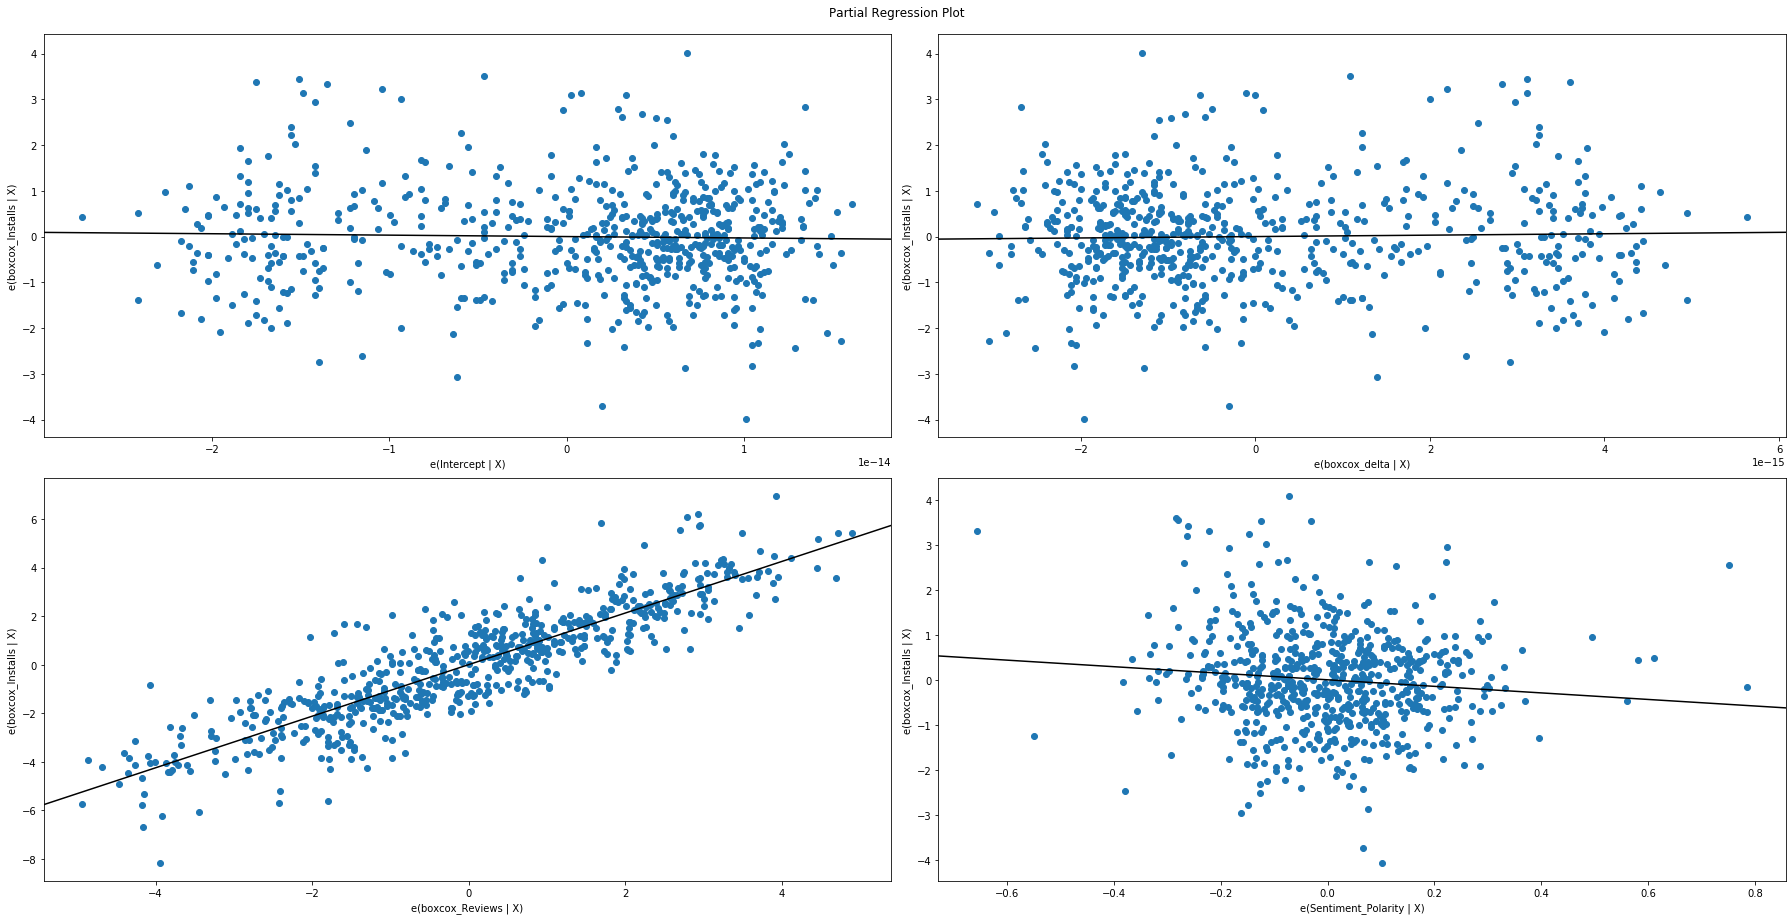

In [153]:
fig = plt.figure(figsize=(25,13))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)

In [157]:
X_train_refined = overall_cleaner(X_train, ['boxcox_delta','boxcox_Reviews', 'Sentiment_Polarity'])
X_test_refined = overall_cleaner(X_test, ['boxcox_delta','boxcox_Reviews', 'Sentiment_Polarity'])

In [160]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)
train_res = y_hat_train - y_train
test_res = y_hat_test - y_test

In [163]:
train_rmse = sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = sqrt(mean_squared_error(y_test, y_hat_test))
test_set_r2 = r2_score(y_test, y_hat_test)
print('Train Root Mean Squarred Error:', train_rmse)
print('Test Root Mean Squarred Error:', test_rmse)
print('Test R-squared', test_set_r2)

Train Root Mean Squarred Error: 1.0385588710890363
Test Root Mean Squarred Error: 1.006304544728141
Test R-squared 0.856513665517396


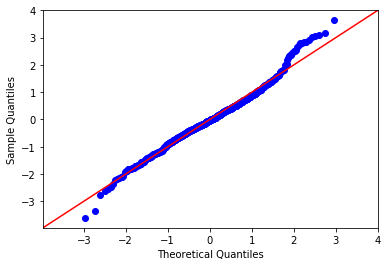

In [164]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45',fit=True)

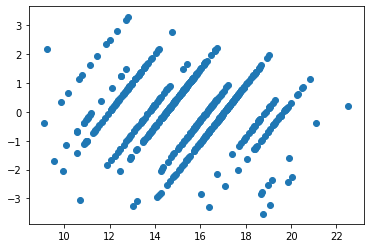

In [165]:
plt.scatter(y_hat_train, train_res)

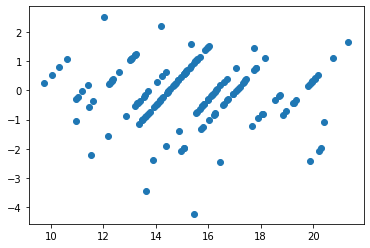

In [166]:
plt.scatter(y_hat_test, test_res)

In [168]:
ridgeReg = Ridge(alpha=0.05, normalize=True)
ridgeReg.fit(X_train_refined, y_train)
ridge_train_score = ridgeReg.score(X_train_refined, y_train)
ridge_test_score = ridgeReg.score(X_test_refined, y_test)

ridge_train_score, ridge_test_score

(0.8009865870518267, 0.8321590543113253)

In [169]:
lassoReg = Lasso(alpha=0.05, normalize=True)
lassoReg.fit(X_train_refined, y_train)
lasso_train_score = lassoReg.score(X_train_refined, y_train)
lasso_test_score = lassoReg.score(X_test_refined, y_test)

lasso_train_score, lasso_test_score

(0.5369309493513468, 0.5605843873501968)

In [170]:
elasticN = ElasticNet(alpha=0.05, normalize=True)
elasticN.fit(X_train_refined, y_train)
elasticN_train = elasticN.score(X_train_refined, y_train)
elasticN_test = elasticN.score(X_test_refined, y_test)

elasticN_train, elasticN_test

(0.06463832456448704, 0.06763938424484572)